In [1]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

### Initialize the environment

In [2]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity= -10.0,
    enable_wind= False,
    wind_power= 5.0,
    turbulence_power = 0.5,
)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Define Neural Network Architecture.

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Define hyperparameter

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [5]:
## Use GPU when it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent 

In [6]:
class Agent():

    def __init__(self, state_size, action_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [7]:
class ReplayBuffer:
    

    def __init__(self, action_size, buffer_size, batch_size, seed):
    
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### Training Process

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import torch
import time

def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    times = []                         # list containing training times per episode
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()       # start timer for episode
        state = env.reset()
        if isinstance(state, tuple):   # handle case where env.reset() returns a tuple
            state = state[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)  # unpack all returned values
            if isinstance(next_state, tuple):  # handle case where next_state is a tuple
                next_state = next_state[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done or truncated:  # break if the episode is done or truncated
                break 
        end_time = time.time()     # end timer for episode
        times.append(end_time - start_time)  # save training time for episode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            checkpoint_filename = f'checkpoint_eps_dec_{eps_decay:.2f}.pth'
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)
            break
    return scores, times

# Example usage
agent = Agent(state_size=8, action_size=4, seed=0)
scores, times = dqn()


Episode 100	Average Score: -166.85	Training Time: 0.18s
Episode 200	Average Score: -137.43	Training Time: 0.13s
Episode 300	Average Score: -113.33	Training Time: 1.70s
Episode 394	Average Score: -60.36	Training Time: 0.16ss

KeyboardInterrupt: 

### Epsilon sensitivity

In [14]:
# Loop over different epsilon parameters
epsilons_results = {}
eps_dec_results = {}

eps_start_values = [1.0, 0.95, 0.90, 0.85, 0.80]  # Example values for eps_start
eps_dec_values = [ 0.995, 0.990, 0.9, 0.8]

# for eps_start in eps_start_values:
#     print(f"Running DQN with eps_start={eps_start}")
#     agent = Agent(state_size=8, action_size=4, seed=0)
#     scores, times = dqn(eps_start=eps_start)
#     epsilons_results[eps_start] = {
#         "scores": scores,
#         "times": times
#     }

for eps_dec in eps_dec_values:
    print(f"Running DQN with eps_dec={eps_dec}")
    agent = Agent(state_size=8, action_size=4, seed=0)
    scores, times = dqn(eps_decay=eps_dec)
    eps_dec_results[eps_dec] = {
        "scores": scores,
        "times": times
    }

Running DQN with eps_dec=0.995
Episode 100	Average Score: -159.83	Training Time: 0.05s
Episode 200	Average Score: -114.99	Training Time: 0.26s
Episode 300	Average Score: -66.69	Training Time: 1.46ss
Episode 400	Average Score: -43.43	Training Time: 1.69s
Episode 500	Average Score: -19.48	Training Time: 1.60s
Episode 600	Average Score: 92.12	Training Time: 0.73ss
Episode 689	Average Score: 200.41	Training Time: 0.38s
Environment solved in 589 episodes!	Average Score: 200.41
Running DQN with eps_dec=0.99
Episode 100	Average Score: -198.97	Training Time: 0.11s
Episode 200	Average Score: -66.40	Training Time: 1.17ss
Episode 300	Average Score: -65.45	Training Time: 1.92s
Episode 400	Average Score: -83.72	Training Time: 0.16s
Episode 500	Average Score: -44.68	Training Time: 1.53s
Episode 600	Average Score: -26.78	Training Time: 1.74s
Episode 700	Average Score: -17.02	Training Time: 1.57s
Episode 800	Average Score: -7.43	Training Time: 1.36ss
Episode 900	Average Score: 19.22	Training Time: 1.9

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import torch
import time
import random
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn as nn

# Assuming all other classes (QNetwork, Agent, ReplayBuffer) are defined as previously shown

def dqn(gamma, n_episodes=1000, max_t=1000, eps_start=0.85, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    times = []                         # list containing training times per episode
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()       # start timer for episode
        state = env.reset()
        if isinstance(state, tuple):   # handle case where env.reset() returns a tuple
            state = state[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)  # unpack all returned values
            if isinstance(next_state, tuple):  # handle case where next_state is a tuple
                next_state = next_state[0]
            agent.step(state, action, reward, next_state, done, gamma)
            state = next_state
            score += reward
            if done or truncated:  # break if the episode is done or truncated
                break 
        end_time = time.time()     # end timer for episode
        times.append(end_time - start_time)  # save training time for episode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            checkpoint_filename = f'checkpoint_gamma_{gamma:.2f}.pth'
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)
            break
    return scores, times

# Example usage
gamma_list = [0.99, 0.9, 0.8]
all_scores = {}
all_times = {}

gamma_results = {}

for gamma in gamma_list:
    print(f"\nRunning DQN with gamma = {gamma}")
    # agent = Agent(state_size=8, action_size=4, seed=0)
    scores, times = dqn(gamma=gamma)
    gamma_results[gamma] = {
        "scores": scores,
        "times": times
    }



Running DQN with gamma = 0.99


TypeError: step() takes 6 positional arguments but 7 were given

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


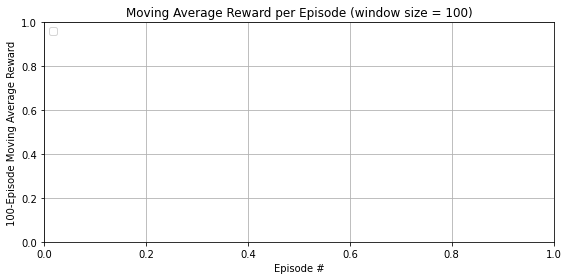

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


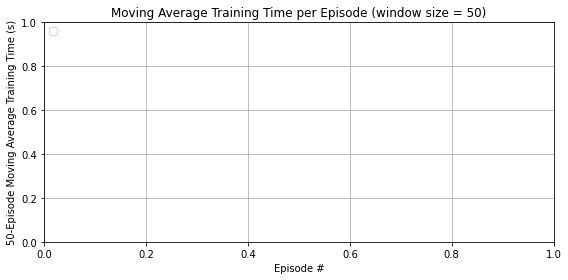

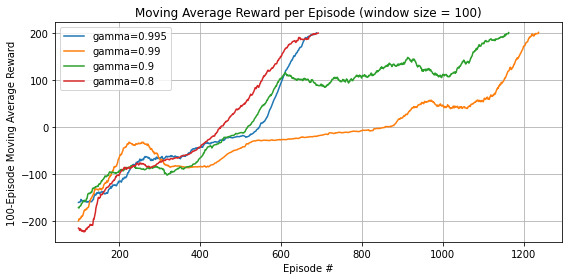

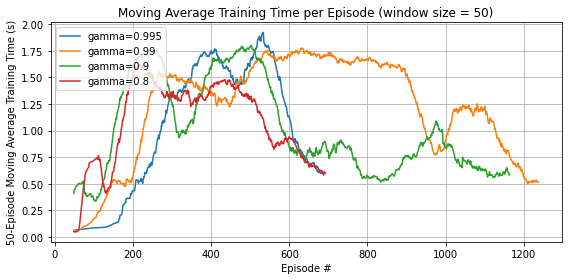

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_moving_average_scores(epsilons_results, window_size=100):
    plt.figure(figsize=(8, 4))

    # Loop through the different epsilon values and plot the moving averages for scores
    for eps_start, results in epsilons_results.items():
        scores = results["scores"]

        # Calculate the moving average for scores
        if len(scores) >= window_size:
            moving_average_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
            plt.plot(np.arange(window_size-1, len(scores)), moving_average_scores, label=f'gamma={eps_start}')
    
    # Customize the score plot
    plt.xlabel('Episode #')
    plt.ylabel(f'{window_size}-Episode Moving Average Reward')
    plt.legend(loc='upper left')
    plt.grid()
    plt.title(f'Moving Average Reward per Episode (window size = {window_size})')
    plt.tight_layout()
    plt.show()

def plot_moving_average_times(epsilons_results, window_size=50):
    plt.figure(figsize=(8, 4))

    # Loop through the different epsilon values and plot the moving averages for times
    for eps_start, results in epsilons_results.items():
        times = results["times"]

        # Calculate the moving average for times
        if len(times) >= window_size:
            moving_average_times = np.convolve(times, np.ones(window_size)/window_size, mode='valid')
            plt.plot(np.arange(window_size-1, len(times)), moving_average_times, label=f'gamma={eps_start}')

    # Customize the time plot
    plt.xlabel('Episode #')
    plt.ylabel(f'{window_size}-Episode Moving Average Training Time (s)')
    plt.legend(loc='upper left')
    plt.grid()
    plt.title(f'Moving Average Training Time per Episode (window size = {window_size})')
    plt.tight_layout()
    plt.show()

# Example usage
plot_moving_average_scores(epsilons_results)
plot_moving_average_times(epsilons_results)

plot_moving_average_scores(eps_dec_results)
plot_moving_average_times(eps_dec_results)

# plot_moving_average_scores(gamma_results)
# plot_moving_average_times(gamma_results)


### Test and animate it with Video

In [ ]:
import glob
import io
import base64
import torch
import gym
from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name, checkpoint):
    env = gym.make(env_name, render_mode='human')
    env = RecordVideo(env, video_folder='video', episode_trigger=lambda x: True)
    agent.qnetwork_local.load_state_dict(torch.load(checkpoint))
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        if done or truncated:
            break
    env.close()
    env = None  # Ensure the environment is properly closed

def run_agent_episodes(agent, env_name, checkpoint, num_episodes=100):
    env = gym.make(env_name)
    agent.qnetwork_local.load_state_dict(torch.load(checkpoint))
    rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        rewards.append(total_reward)

    env.close()
    plot_rewards_statistics(rewards)

def plot_rewards_statistics(rewards):
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print('Average reward:', avg_reward)
    print('standard deviation:', std_reward)

    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(rewards, label='Reward per Episode',)
    plt.axhline(avg_reward, linestyle='--', label='Average Reward', color='red')
    plt.fill_between(range(len(rewards)), avg_reward - std_reward, avg_reward + std_reward, alpha=0.2, label='Standard Deviation', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards over 100 Episodes')
    plt.legend()
    plt.show()


Running agent for checkpoint checkpoint_gamma_0.99.pth
Running agent for checkpoint checkpoint_gamma_0.90.pth
Running agent for checkpoint checkpoint_gamma_0.80.pth
Average reward (gam=0.99): 181.70896813363314
standard deviation (gam=0.99): 89.426064317811
Average reward (gam=0.90): 212.25166605183244
standard deviation (gam=0.90): 103.12894551978275
Average reward (gam=0.80): 224.5408650724573
standard deviation (gam=0.80): 40.20542665939347


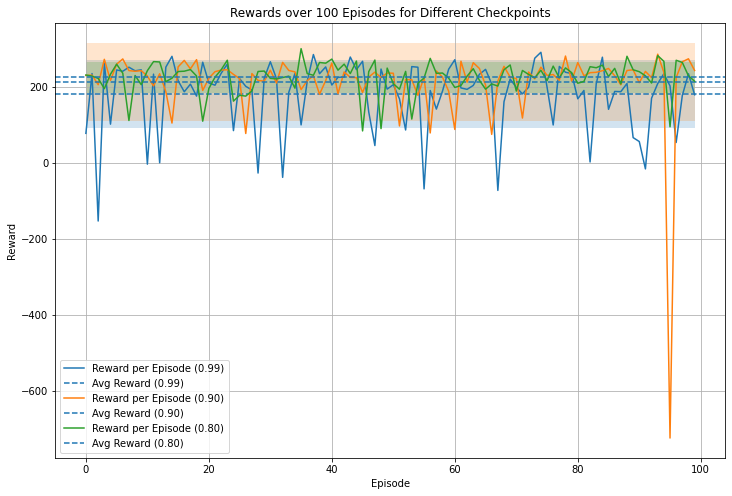

In [17]:
import glob
import io
import base64
import torch
import gym
from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name, checkpoint):
    env = gym.make(env_name, render_mode='human')
    env = RecordVideo(env, video_folder='video', episode_trigger=lambda x: True)
    agent.qnetwork_local.load_state_dict(torch.load(checkpoint))
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        if done or truncated:
            break
    env.close()
    env = None  # Ensure the environment is properly closed

def run_agent_episodes(agent, env_name, checkpoint, num_episodes=100):
    env = gym.make(env_name)
    agent.qnetwork_local.load_state_dict(torch.load(checkpoint))
    rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        rewards.append(total_reward)

    env.close()
    return rewards

def plot_rewards_statistics_for_checkpoints(all_rewards, checkpoint_names):    
    plt.figure(figsize=(12, 8))
    plt.grid()

    for rewards, checkpoint_name in zip(all_rewards, checkpoint_names):
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f'Average reward (gam={checkpoint_name}):', avg_reward)
        print(f'standard deviation (gam={checkpoint_name}):', std_reward)

        plt.plot(rewards, label=f'Reward per Episode ({checkpoint_name})')
        plt.axhline(avg_reward, linestyle='--', label=f'Avg Reward ({checkpoint_name})')
        plt.fill_between(range(len(rewards)), avg_reward - std_reward, avg_reward + std_reward, alpha=0.2)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards over 100 Episodes for Different Checkpoints')
    plt.legend()
    plt.show()

# Loop through different checkpoints
checkpoint_files = [ 'checkpoint_gamma_0.99.pth', 'checkpoint_gamma_0.90.pth', 'checkpoint_gamma_0.80.pth']  # Example filenames
all_rewards = []
checkpoint_names = []

agent = Agent(state_size=8, action_size=4, seed=0)
env_name = 'LunarLander-v2'

for checkpoint in checkpoint_files:
    print(f"Running agent for checkpoint {checkpoint}")
    rewards = run_agent_episodes(agent, env_name, checkpoint)
    all_rewards.append(rewards)
    checkpoint_names.append(checkpoint.split('_')[-1].replace('.pth', ''))

# Plot all the results in one graph
plot_rewards_statistics_for_checkpoints(all_rewards, checkpoint_names)


In [ ]:

agent = Agent(state_size=8, action_size=4, seed=0)
checkpoint = 'checkpoint.pth'
run_agent_episodes(agent, 'LunarLander-v2', checkpoint)


In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
checkpoint = 'checkpoint_eps_0.98.pth'
show_video_of_model(agent, 'LunarLander-v2', checkpoint)